In [1]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Carregar os dados
data = pd.read_csv('heart_disease.csv')

In [3]:
data.head()

,idade,pressao_repouso,colesterol,fc_maxima,depressao_st,target
0,20-40,normal,limítrofe,baixa,nenhuma,0
1,20-40,normal,alto,alta,moderada,1
2,20-40,normal,normal,alta,nenhuma,0
3,60-80,alta,alto,alta,moderada,1
4,20-40,alta,limítrofe,normal,nenhuma,0


In [4]:
# 2. Converter variáveis categóricas para numéricas
label_encoders = {}
label_mappings = {}

for col in data.columns:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [5]:
data.head()

,idade,pressao_repouso,colesterol,fc_maxima,depressao_st,target
0,0,2,1,1,2,0
1,0,2,0,0,1,1
2,0,2,2,0,2,0
3,2,0,0,0,1,1
4,0,0,1,2,2,0


In [6]:
# Exibir mapeamento de categorias
print("\n=== MAPEAMENTO DE CATEGORIAS ===")
for col, mapping in label_mappings.items():
    print(f"\nVariável: {col}")
    print("-" * 30)
    for categoria, codigo in sorted(mapping.items(), key=lambda x: x[1]):
        print(f"{categoria.ljust(15)} → {codigo}")


=== MAPEAMENTO DE CATEGORIAS ===

Variável: idade
------------------------------
20-40           → 0
40-60           → 1
60-80           → 2

Variável: pressao_repouso
------------------------------
alta            → 0
elevada         → 1
normal          → 2

Variável: colesterol
------------------------------
alto            → 0
limítrofe       → 1
normal          → 2

Variável: fc_maxima
------------------------------
alta            → 0
baixa           → 1
normal          → 2

Variável: depressao_st
------------------------------
leve            → 0
moderada        → 1
nenhuma         → 2


In [7]:
# 3. Dividir em treino e teste
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [8]:
# 4. Definir estrutura da rede
model = BayesianNetwork([
    ('idade', 'pressao_repouso'),
    ('idade', 'colesterol'),
    ('pressao_repouso', 'target'),
    ('colesterol', 'target'),
    ('fc_maxima', 'target'),
    ('depressao_st', 'target')
])


In [9]:
# 5. Treinar o modelo
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

In [10]:
# 6. Fazer inferência
inference = VariableElimination(model)

In [11]:
# 7. Verificar distribuição real para casos similares
print("\nDistribuição real para casos similares:")
sample_case_filter = (
    (data['idade'] == label_mappings['idade']['20-40']) & 
    (data['pressao_repouso'] == label_mappings['pressao_repouso']['normal']) &
    (data['colesterol'] == label_mappings['colesterol']['normal']) &
    (data['fc_maxima'] == label_mappings['fc_maxima']['normal']) &
    (data['depressao_st'] == label_mappings['depressao_st']['moderada'])
)

similar_cases = data[sample_case_filter]
print(similar_cases['target'].value_counts(normalize=True))


Distribuição real para casos similares:
1    1.0
Name: target, dtype: float64


In [12]:
# 8. Testar diferentes casos
test_cases = [
    {
        'description': "Caso jovem saudável",
        'idade': '20-40',
        'pressao_repouso': 'normal',
        'colesterol': 'normal',
        'fc_maxima': 'normal',
        'depressao_st': 'nenhuma'
    },
    {
        'description': "Caso risco moderado",
        'idade': '40-60',
        'pressao_repouso': 'alta',
        'colesterol': 'limítrofe',
        'fc_maxima': 'normal',
        'depressao_st': 'leve'
    },
    {
        'description': "Caso alto risco",
        'idade': '60-80',
        'pressao_repouso': 'alta',
        'colesterol': 'alto',
        'fc_maxima': 'alta',
        'depressao_st': 'moderada'
    }
]

print("\nTestando diferentes casos:")
for case in test_cases:
    # Converter para valores codificados
    encoded_case = {
        'idade': label_mappings['idade'][case['idade']],
        'pressao_repouso': label_mappings['pressao_repouso'][case['pressao_repouso']],
        'colesterol': label_mappings['colesterol'][case['colesterol']],
        'fc_maxima': label_mappings['fc_maxima'][case['fc_maxima']],
        'depressao_st': label_mappings['depressao_st'][case['depressao_st']]
    }
    
    #faz a inferência (consulta) na rede bayesiana e retorna com as probabilidades para cada classe de target
    prob = inference.query(variables=['target'], evidence=encoded_case)
    print(f"\n{case['description']}:")
    print(f"Probabilidade de doença cardíaca: {prob.values[1]*100:.2f}%")
    print("Valores usados:")
    for k, v in case.items():
        if k != 'description':
            print(f"  {k}: {v} (codificado como {encoded_case[k]})")


Testando diferentes casos:

Caso jovem saudável:
Probabilidade de doença cardíaca: 0.00%
Valores usados:
  idade: 20-40 (codificado como 0)
  pressao_repouso: normal (codificado como 2)
  colesterol: normal (codificado como 2)
  fc_maxima: normal (codificado como 2)
  depressao_st: nenhuma (codificado como 2)

Caso risco moderado:
Probabilidade de doença cardíaca: 25.00%
Valores usados:
  idade: 40-60 (codificado como 1)
  pressao_repouso: alta (codificado como 0)
  colesterol: limítrofe (codificado como 1)
  fc_maxima: normal (codificado como 2)
  depressao_st: leve (codificado como 0)

Caso alto risco:
Probabilidade de doença cardíaca: 100.00%
Valores usados:
  idade: 60-80 (codificado como 2)
  pressao_repouso: alta (codificado como 0)
  colesterol: alto (codificado como 0)
  fc_maxima: alta (codificado como 0)
  depressao_st: moderada (codificado como 1)



Relatório de Classificação:
              precision    recall  f1-score   support

  Sem doença       0.91      0.97      0.94       162
  Com doença       0.97      0.90      0.94       168

    accuracy                           0.94       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.94      0.94      0.94       330



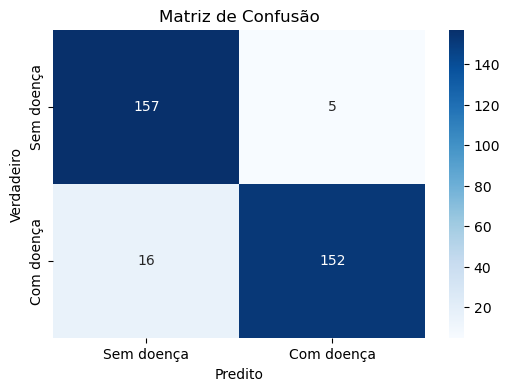

In [13]:
# 9. Avaliar o modelo
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']


#função que faz previsões usando o modelo treinado: itera, consulta e seleciona a classe com maior probabilidade 
def predict(model, data):
    predictions = []
    for _, sample in data.iterrows():
        evidence = sample.to_dict()
        prob = inference.query(variables=['target'], evidence=evidence)
        predictions.append(prob.values.argmax())
    return predictions

y_pred = predict(model, X_test)


print("\nRelatório de Classificação:")
#Gera métricas de avaliação detalhadas
print(classification_report(y_test, y_pred, target_names=['Sem doença', 'Com doença']))
#precisão, sensibilidade, média harmonica entre precisão e recall e numero de ocorrencias em cada classe



# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sem doença', 'Com doença'],
            yticklabels=['Sem doença', 'Com doença'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [14]:
# testes

In [15]:
print("\nExemplo de inferência para um novo caso:")
print("(Consulte o mapeamento acima para entender os valores codificados)")

sample_case = {
    'idade': label_mappings['idade']['40-60'], 
    'pressao_repouso': label_mappings['pressao_repouso']['alta'],
    'colesterol': label_mappings['colesterol']['alto'],
    'fc_maxima': label_mappings['fc_maxima']['normal'],
    'depressao_st': label_mappings['depressao_st']['nenhuma']
}

prob = inference.query(variables=['target'], evidence=sample_case)
print(f"Probabilidade de doença cardíaca: {prob.values[1]*100:.2f}%")


Exemplo de inferência para um novo caso:
(Consulte o mapeamento acima para entender os valores codificados)
Probabilidade de doença cardíaca: 45.45%
